# **miniML Tutorial**



## Setting up

We begin by importing the required parts of the miniML package.

## Running miniML

In [1]:
import sys
sys.path.append('./core/')
from miniML import MiniTrace, EventDetection

2024-05-31 16:57:29.840098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


For the actual data analysis, we first need to load the data and create a miniML *MiniTrace* object. Currently accepted file formats are HDF5, Axon ABF and HEKA DAT. In this example, we load the dataset ['mini_data'] from an .h5 file. Data can be scaled for convenience. Provide the sampling interval (in seconds, e.g., *sampling=1e-5*) if the sampling rate is not 50 kHz.

In [3]:
filename = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/data_verji/OP230808/23808033.abf' #'./example_data/gc_mini_trace.h5'
unit = 'pA'

# get from h5 file
trace = MiniTrace.from_axon_file_MP(filepath=filename,
                                 channel = 4,
                                 unit=unit,
                                 first_point = 0, 
                                 last_point = 5000,
                                 sweeps_delete = [range(25)])
                                

In [4]:
# filename = './example_data/gc_mini_trace.h5'
# scaling = 1e12
# unit = 'pA'

# # get from h5 file
# trace = MiniTrace.from_h5_file(filename=filename,
#                                tracename='mini_data',
#                                scaling=scaling,
#                                unit=unit)

Let's plot and inspecet the loaded data:

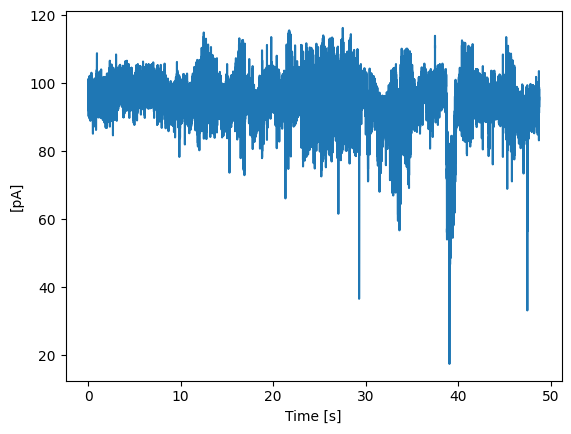

In [5]:
trace.plot_trace()

Next, we need to create and initialize a miniML *EventDetection* object. Required arguments are a miniML MiniTrace object to work on and the path to a miniML model file. Optionally, the threshold for event detection can be adjusted (range, 0–1). The batch_size parameter can be changed to reduce runtime when running on a GPU (caveat: too large batch sizes can cause poor model prediction performance).

In [7]:
win_size = 900
stride = int(win_size/30)
direction = 'negative'

detection = EventDetection(data = trace,
                        model_path='./model/GC_lstm_model.h5',
                          # model_path = '/Users/verjim/miniML_multipatch/model_training/kaggle_output_model_training_dataset1/lstm_transfer_dataset1.h5',
                           window_size = win_size,
                           model_threshold = 0.5,
                           batch_size = 512,
                           event_direction = direction,
                           training_direction = 'negative',
                           compile_model = True)

Model loaded from ./model/GC_lstm_model.h5


To detect events, we have to call the **detect_events()** method. We can provide a stride length, i.e. numbers of samples the analysis window is shifted by for each iteration. Defaults to 20 (i.e., 1/30 of the window size used for model inference). Set the eval flag to **False** if you do not want to analyse the detected events.

In [8]:
detection.detect_events(stride=stride,
                        eval=True,
                        verbose=True,
                        convolve_win = 15, #the Hann wondow for filtering. presserving the peaks?
                        resample_to_600 = True) #always true for transfer learning

## Inspect the results

After the event detection and analysis, we can create some plots. MiniML includes several plotting methods: 

**plot_prediction()** shows the model inference trace, optinally together with the data and marked events. Note that we plot a filtered version of the trace in this example.

**plot_events()** creates a figure with all detected events overlaid. 

**plot_event_histogram()** plots a histogram of event amplitudes (optional: inter-event-intervals). Set *cumulative=True* for a cumulative probability plot.

In [ ]:
detection.plot_prediction(include_data=True, plot_filtered_prediction=True, plot_filtered_trace=True)
detection.plot_events()
detection.plot_event_histogram(plot='amplitude', cumulative=False)

## Save results to file

Finally, we can save the results to file for later use. The **save_to_pickle()** method saves the data in pickle format (essentially a python dictionary). If desired, the mini trace and the generated prediction trace can be saved as well. Note that this will increase file size.

In [ ]:
detection.save_to_pickle(filename='./example_data/results/gc_mini_trace_results.pickle', 
                         include_prediction=True, 
                         include_data=False)

The **save_to_h5()** method saves the detected events and the individual event statistics to a specified HDF5 file. It also includes average results for amplitude, charge, frequency, etc.

In [ ]:
detection.save_to_h5('./example_data/results/gc_mini_trace_results.h5')

In addition, results can be saved in a delimited text format using **save_to_csv()**. This methods takes a destination folder path and saves two .csv files containing event population statistics and individual event statistics, respectively.

In [ ]:
detection.save_to_csv(path='./example_data/results', overwrite=True)